In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

import time
import torch

from tqdm import tqdm

from torchegranate.distributions import *
from torchegranate.hmm import HiddenMarkovModel, Node

from pomegranate import State, NormalDistribution, IndependentComponentsDistribution, DiscreteDistribution
from pomegranate import HiddenMarkovModel as HMM

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,torch,pomegranate

Populating the interactive namespace from numpy and matplotlib
numpy      : 1.23.4
scipy      : 1.9.3
torch      : 1.12.1
pomegranate: 0.14.8

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.15.0-197-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



### Normal Distribution w/ Diagonal Covariance

In [2]:
n, l, d = 200, 50, 10
k = 50


X = numpy.random.randn(n, l, d)
Xt = torch.tensor(X)

d1s, d2s, d3s = [], [], []
for i in range(k):
    mus = numpy.random.randn(d)

    d1 = IndependentComponentsDistribution([NormalDistribution(mu, 1) for mu in mus])
    d2 = Normal(torch.tensor(mus), torch.ones(d), covariance_type='diag')
    d3 = Normal(torch.tensor(mus), torch.ones(d), covariance_type='diag')

    d1s.append(d1)
    d2s.append(d2)
    d3s.append(d3)


starts = torch.ones(k, dtype=torch.float64) / k
ends = torch.ones(k, dtype=torch.float64) / (k+1)
edges = torch.ones(k, k, dtype=torch.float64) / (k+1)


model1 = HMM.from_matrix(edges, d1s, starts, ends)
model2 = HiddenMarkovModel(nodes=d2s, edges=edges, starts=starts, ends=ends, kind='sparse', max_iter=10, verbose=True)
model2.bake()
model3 = HiddenMarkovModel(nodes=d3s, edges=torch.clone(edges), starts=torch.clone(starts), ends=torch.clone(ends), max_iter=10, kind='dense', verbose=True)
model3.bake()

/home/jmschr/anaconda3/lib/python3.9/site-packages/torchegranate-0.0.1-py3.9.egg/torchegranate/_dense_hmm.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jmschr/anaconda3/lib/python3.9/site-packages/torchegranate-0.0.1-py3.9.egg/torchegranate/_dense_hmm.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jmschr/anaconda3/lib/python3.9/site-packages/torchegranate-0.0.1-py3.9.egg/torchegranate/_dense_hmm.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Forward

In [3]:
%timeit [model1.forward(x) for x in X]
%timeit model2.forward(X)
%timeit model3.forward(X)

959 ms ± 7.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
184 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
130 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Backward

In [4]:
%timeit [model1.backward(x) for x in X]
%timeit model2.backward(X)
%timeit model3.backward(X)

995 ms ± 7.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
319 ms ± 42.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
133 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Forward-Backward

In [5]:
%timeit [model1.forward_backward(x) for x in X]
%timeit model2.forward_backward(X)
%timeit model3.forward_backward(X)

2.58 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
801 ms ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
370 ms ± 39.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Fitting

In [6]:
_ = model1.fit(X, max_iterations=10, verbose=True)
sum(model1.log_probability(x) for x in X)

[1] Improvement: 11916.92540384506	Time (s): 2.761
[2] Improvement: 356.23982110453653	Time (s): 2.799
[3] Improvement: 187.82563967100577	Time (s): 2.811
[4] Improvement: 132.1274677386391	Time (s): 2.817
[5] Improvement: 107.64460236663581	Time (s): 2.816
[6] Improvement: 95.06285029207356	Time (s): 2.816
[7] Improvement: 87.14057147293352	Time (s): 2.81
[8] Improvement: 81.8166760643071	Time (s): 2.814
[9] Improvement: 78.61675650975667	Time (s): 2.804
[10] Improvement: 76.616654075915	Time (s): 2.813
Total Training Improvement: 13120.016443140863
Total Training Time (s): 30.7974


/tmp/ipykernel_49503/2413083255.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum(model1.log_probability(x) for x in X)


-141610.99530855467

In [7]:
model2.fit(X)
model2.log_probability(X).sum()

[1] Improvement: 11916.924049986032, Time: 0.9671s
[2] Improvement: 356.2397617994575, Time: 0.8338s
[3] Improvement: 187.8250123585749, Time: 0.8203s
[4] Improvement: 132.1275977602927, Time: 0.8282s
[5] Improvement: 107.64466150157386, Time: 0.8327s
[6] Improvement: 95.062770339282, Time: 0.8272s
[7] Improvement: 87.14074739645002, Time: 0.832s
[8] Improvement: 81.81688827590551, Time: 0.8347s
[9] Improvement: 78.61642209693673, Time: 0.8035s
[10] Improvement: 76.61670887985383, Time: 1.664s


tensor(-141685.9139, dtype=torch.float64)

In [8]:
model3.fit(X)
model3.log_probability(X).sum()

[1] Improvement: 11916.924035742384, Time: 0.3742s
[2] Improvement: 356.2398789973522, Time: 0.4464s
[3] Improvement: 187.82526078561204, Time: 0.4137s
[4] Improvement: 132.12753497209633, Time: 0.3989s
[5] Improvement: 107.64437899994664, Time: 0.3825s
[6] Improvement: 95.06291119300295, Time: 0.4098s
[7] Improvement: 87.14107854760368, Time: 0.399s
[8] Improvement: 81.81658541041543, Time: 0.3975s
[9] Improvement: 78.61654813570203, Time: 0.3884s
[10] Improvement: 76.61647296641604, Time: 0.8219s


tensor(-141685.9138, dtype=torch.float64)

### Categorical Distributions

In [9]:
n, l, d = 200, 50, 10
k = 50


X = numpy.random.choice(4, size=(n, l, d))
Xt = torch.tensor(X)

d1s, d2s, d3s = [], [], []
for i in range(k):
    mus = numpy.abs(numpy.random.randn(d, 4))
    mus = mus / mus.sum(axis=1, keepdims=True)

    d_ = [DiscreteDistribution({i: mu[i] for i in range(4)}) for mu in mus]
    d1 = IndependentComponentsDistribution(d_)
    d2 = Categorical(mus)
    d3 = Categorical(mus)

    d1s.append(d1)
    d2s.append(d2)
    d3s.append(d3)


starts = torch.ones(k, dtype=torch.float64) / k
ends = torch.ones(k, dtype=torch.float64) / k
edges = torch.ones(k, k, dtype=torch.float64) / k


model1 = HMM.from_matrix(edges, d1s, starts, ends)
model2 = HiddenMarkovModel(nodes=d2s, edges=edges, starts=starts, ends=ends, kind='sparse', max_iter=10, verbose=True)
model2.bake()
model3 = HiddenMarkovModel(nodes=d3s, edges=torch.clone(edges), starts=torch.clone(starts), ends=torch.clone(ends), max_iter=10, kind='dense', verbose=True)
model3.bake()

### Forward

In [10]:
%timeit [model1.forward(x) for x in X]
%timeit model2.forward(X)
%timeit model3.forward(X)

1.02 s ± 9.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
198 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
150 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Backward

In [11]:
%timeit [model1.backward(x) for x in X]
%timeit model2.backward(X)
%timeit model3.backward(X)

1.05 s ± 5.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
362 ms ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
150 ms ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Increased Size of Dense Transition Matrix

In [12]:
times1, times2, times3 = [], [], []

for k in tqdm(range(10, 351, 10)):
    n, l, d = 200, 50, 10

    X = numpy.random.choice(4, size=(n, l, d))
    Xt = torch.tensor(X)

    d1s, d2s, d3s = [], [], []
    for i in range(k):
        mus = numpy.abs(numpy.random.randn(d, 4))
        mus = mus / mus.sum(axis=1, keepdims=True)

        d_ = [DiscreteDistribution({i: mu[i] for i in range(4)}) for mu in mus]
        d1 = IndependentComponentsDistribution(d_)
        d2 = Categorical(mus)
        d3 = Categorical(mus)

        d1s.append(d1)
        d2s.append(d2)
        d3s.append(d3)


    starts = torch.ones(k, dtype=torch.float64) / k
    ends = torch.ones(k, dtype=torch.float64) / (k+1)
    edges = torch.ones(k, k, dtype=torch.float64) / (k+1)


    model1 = HMM.from_matrix(edges, d1s, starts, ends)
    model2 = HiddenMarkovModel(nodes=d2s, edges=edges, starts=starts, ends=ends, kind='sparse', max_iter=10, verbose=True)
    model2.bake()
    model3 = HiddenMarkovModel(nodes=d3s, edges=torch.clone(edges), starts=torch.clone(starts), ends=torch.clone(ends), max_iter=10, kind='dense', verbose=True)
    model3.bake()
    
    tic = time.time()
    [model1.forward(x) for x in X]
    times1.append(time.time() - tic)
    
    tic = time.time()
    model2.forward(X)
    times2.append(time.time() - tic)
    
    tic = time.time()
    model3.forward(X)
    times3.append(time.time() - tic)

100%|███████████████████████████████████████████| 35/35 [10:45<00:00, 18.44s/it]


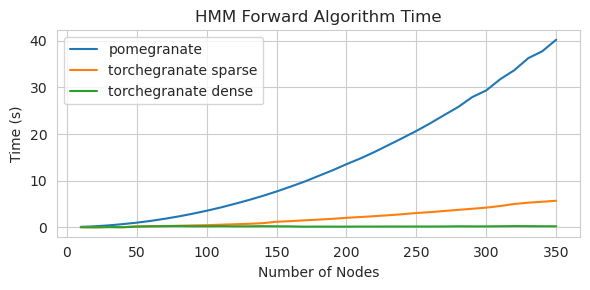

In [13]:
x = range(10, 351, 10)

plt.figure(figsize=(6, 3))
plt.title("HMM Forward Algorithm Time", fontsize=12)
plt.plot(x, times1, label="pomegranate")
plt.plot(x, times2, label="torchegranate sparse")
plt.plot(x, times3, label="torchegranate dense")

plt.xlabel("Number of Nodes", fontsize=10)
plt.ylabel("Time (s)", fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

## Increased Sparsity of Transition Matrix

In [22]:
times1, times2, times3 = [], [], []
ps = 1. / numpy.exp(numpy.arange(3, 10.1, 0.25))

for p in tqdm(ps):
    n, l, d = 200, 50, 10
    k = 2000

    X = numpy.random.choice(4, size=(n, l, d))
    Xt = torch.tensor(X)

    d1s, d2s, d3s = [], [], []
    for i in range(k):
        mus = numpy.abs(numpy.random.randn(d, 4))
        mus = mus / mus.sum(axis=1, keepdims=True)

        d_ = [DiscreteDistribution({i: mu[i] for i in range(4)}) for mu in mus]
        d1 = IndependentComponentsDistribution(d_)
        d2 = Categorical(mus)
        d3 = Categorical(mus)

        d1s.append(d1)
        d2s.append(d2)
        d3s.append(d3)


    starts = torch.ones(k, dtype=torch.float64) / k
    ends = torch.ones(k, dtype=torch.float64)
    
    edges = numpy.ones((k, k), dtype=numpy.float64)
    mask = numpy.random.choice(2, size=(k, k), replace=True, p=[1-p, p])
    
    edges = edges * mask
    z = edges.sum(axis=1, keepdims=True) + 1
    
    edges = torch.tensor(edges / z)
    ends = torch.tensor(ends / z[:, 0])    

    model1 = HMM.from_matrix(edges, d1s, starts, ends)
    model2 = HiddenMarkovModel(nodes=d2s, edges=edges, starts=starts, ends=ends, kind='sparse', max_iter=10, verbose=True)
    model2.bake()
    model3 = HiddenMarkovModel(nodes=d3s, edges=torch.clone(edges), starts=torch.clone(starts), ends=torch.clone(ends), max_iter=10, kind='dense', verbose=True)
    model3.bake()
    
    tic = time.time()
    [model1.forward(x) for x in X]
    times1.append(time.time() - tic)
    
    tic = time.time()
    model2.forward(X)
    times2.append(time.time() - tic)
    
    tic = time.time()
    model3.forward(X)
    times3.append(time.time() - tic)

  0%|                                                    | 0/29 [00:00<?, ?it/s]/tmp/ipykernel_49503/3080411124.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ends = torch.tensor(ends / z[:, 0])
100%|███████████████████████████████████████████| 29/29 [38:23<00:00, 79.43s/it]


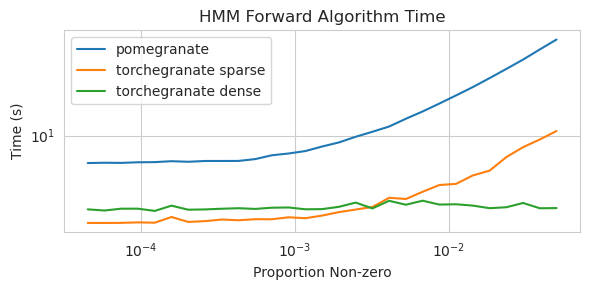

In [26]:
plt.figure(figsize=(6, 3))
plt.title("HMM Forward Algorithm Time", fontsize=12)
plt.plot(ps, times1, label="pomegranate")
plt.plot(ps, times2, label="torchegranate sparse")
plt.plot(ps, times3, label="torchegranate dense")

plt.xlabel("Proportion Non-zero", fontsize=10)
plt.ylabel("Time (s)", fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()